### SKEWNESS STRAT

In [16]:
#import alpaca_trade_api as tradeapi
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.timeframe import TimeFrame
from alpaca.data.requests import StockBarsRequest
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
from scipy.stats import norm
import statsmodels.api as sm
import logging

In [17]:
# Parse the date from the Alpaca API format
def parse_date(t):
    return pd.to_datetime(t).date()

# Clean the DataFrame and calculate necessary fields
def clean(df, ticker):
    df['Date'] = df['timestamp'].apply(parse_date)
    df['Ticker'] = ticker
    df['NextOpen'] = df['open'].shift(-1)
    df['LogReturn'] = np.log(df['close'] / df['close'].shift(1))
    df = df[['Date', 'Ticker', 'close', 'open', 'NextOpen', 'LogReturn']]
    return df

def load(etf):
    api_key = "PKSWBHSXH120YY3ERBM1"
    secret_key = "H3Wgju5jrzoNiiec7nW4uNK789F1ndIWhZScflMg"
    client = StockHistoricalDataClient(api_key, secret_key)
    
    end_date = dt.datetime.now()
    start_date = end_date - dt.timedelta(days=3650)  # 10 years
    
    try:
        request_params = StockBarsRequest(
            symbol_or_symbols=etf,
            timeframe=TimeFrame.Day,
            start=start_date,
            end=end_date,
            adjustment='all'
        )
        
        bars = client.get_stock_bars(request_params).df
        df = bars.reset_index()
        return clean(df, etf)
    
    except APIError as e:
        logging.error(f"API Error: {e}")
        logging.error("Ensure your API key and secret are correct, and check your account permissions.")
        raise
    except Exception as e:
        logging.error(f"Unexpected error: {e}")
        raise

In [21]:
# Example usage:
spy = load('SPY')
print(spy.head())

         Date Ticker   close    open  NextOpen  LogReturn
0  2016-01-04    SPY  175.03  174.57    175.36        NaN
1  2016-01-05    SPY  175.33  175.36    172.69   0.001713
2  2016-01-06    SPY  173.11  172.69    170.07  -0.012743
3  2016-01-07    SPY  168.96  170.07    169.95  -0.024265
4  2016-01-08    SPY  167.11  169.95    168.05  -0.011010


In [23]:
# Calculate the rolling mean and rolling standard deviation of LogReturn
spy['Avg'] = spy['LogReturn'].rolling(window=256).mean()
spy['Dev'] = spy['LogReturn'].rolling(window=256).std()

# Calculate the daily skewness component
spy['SkewDay'] = ((spy['LogReturn'] - spy['Avg']) / spy['Dev']) ** 3

# Calculate the rolling mean of the daily skewness component to get Skew
spy['Skew'] = spy['SkewDay'].rolling(window=256).mean()

# Drop rows where Skew is NaN
spy = spy.dropna(subset=['Skew'])

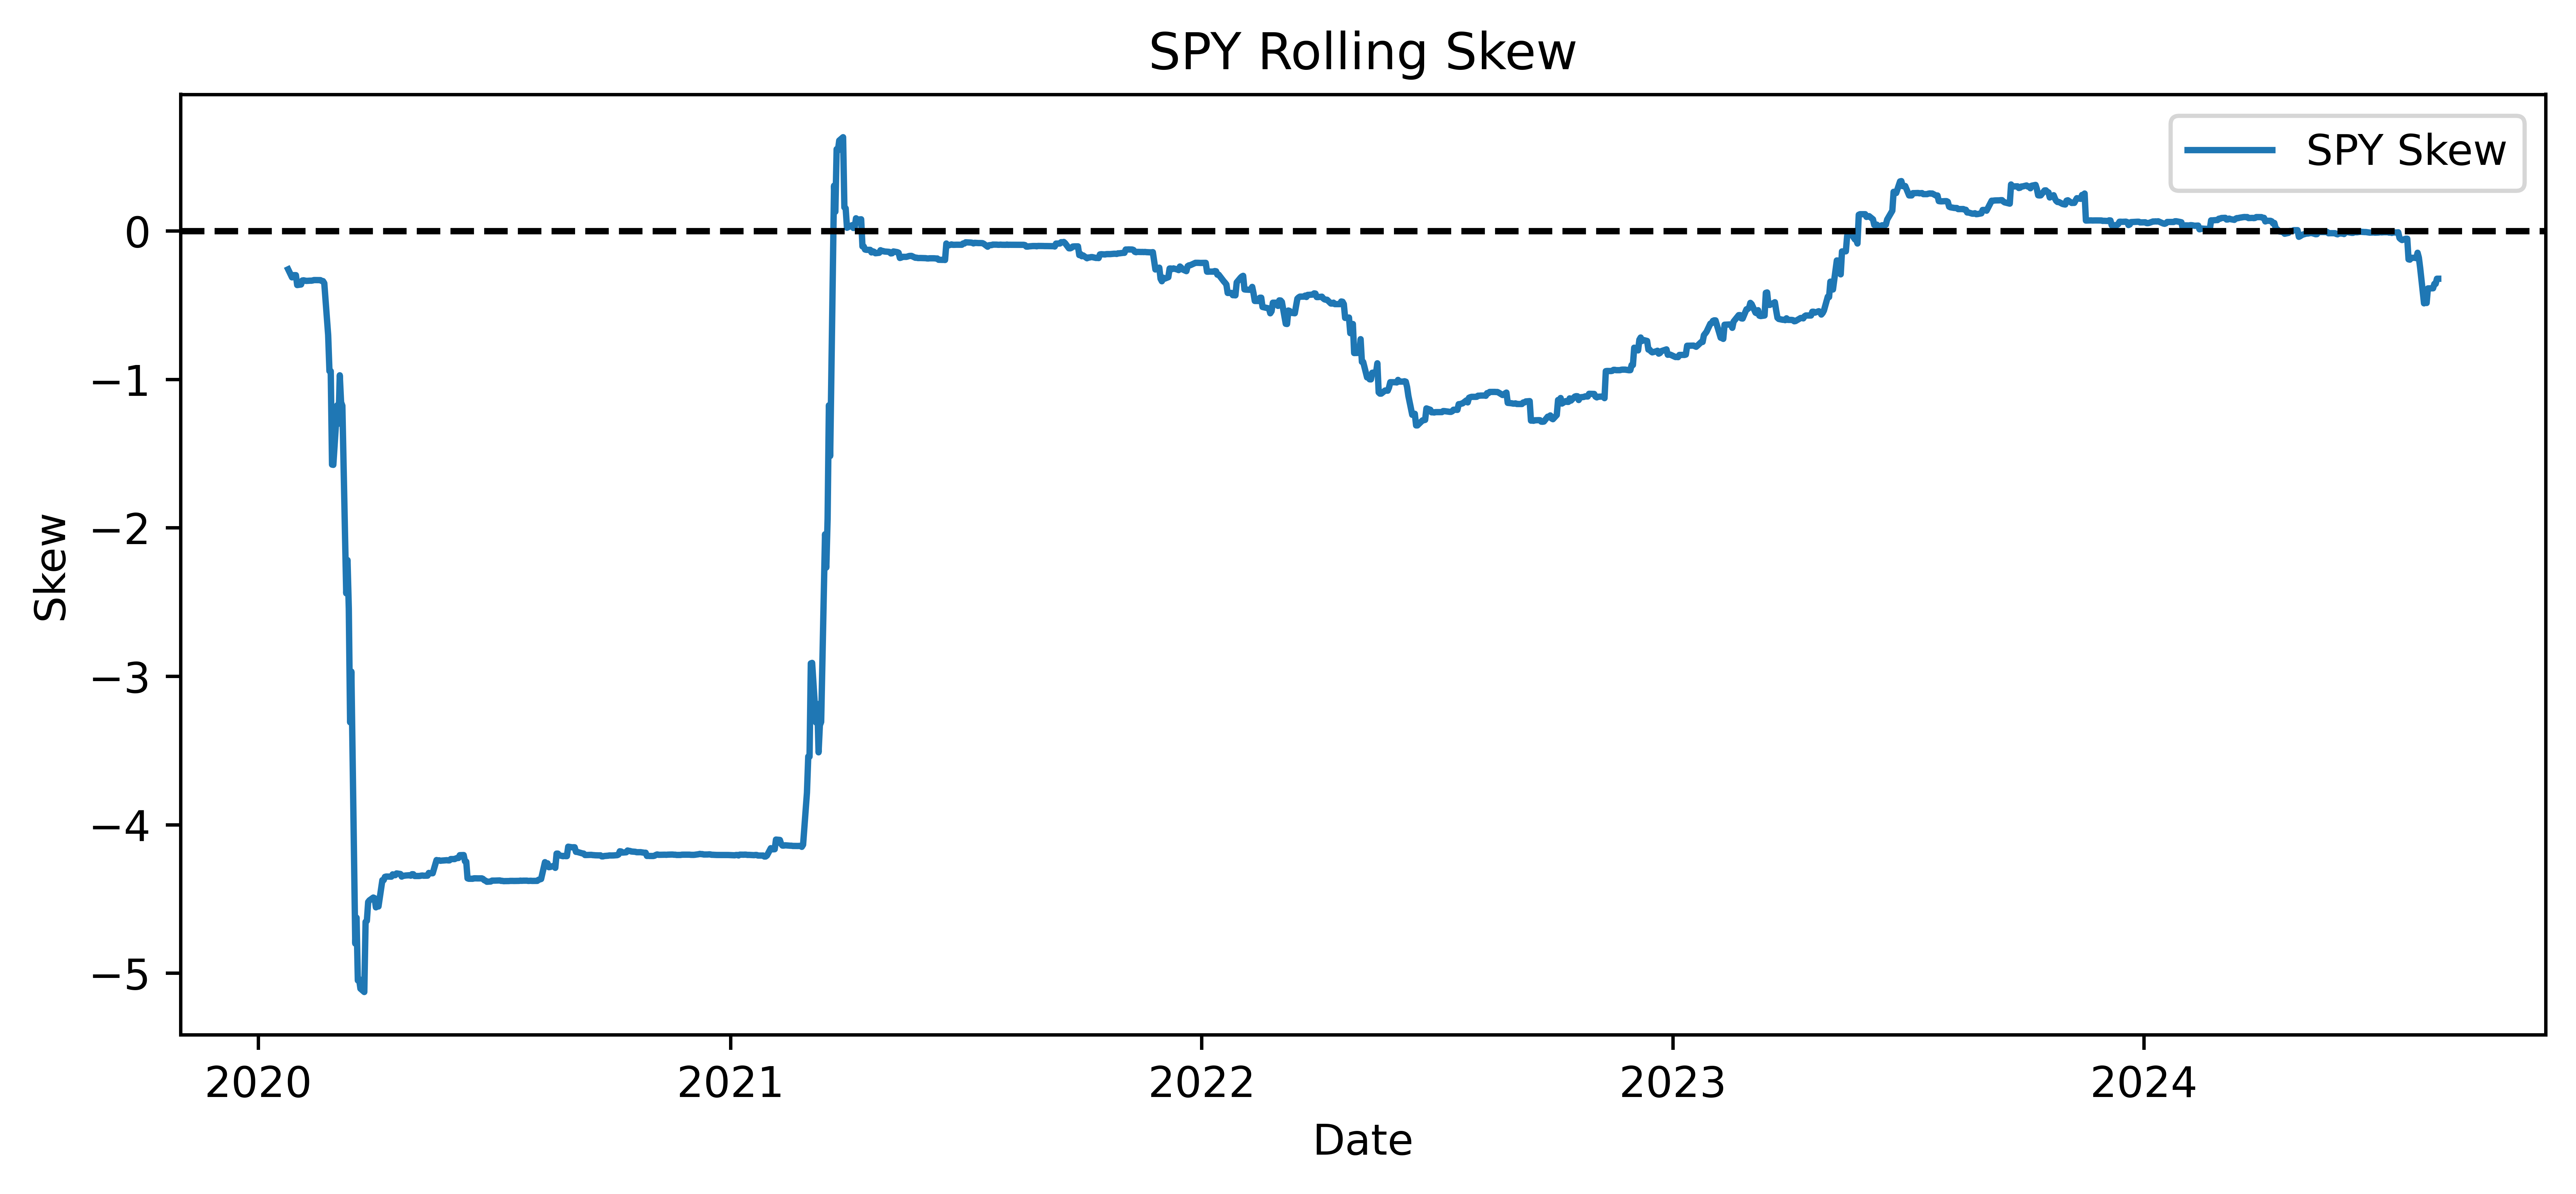

In [24]:
# Plot the results
plt.figure(figsize=(10, 4), dpi=900)
plt.plot(spy['Date'], spy['Skew'], label="SPY Skew")
plt.axhline(y=0, color='black', linestyle='--', label=None)
plt.xlabel("Date")
plt.ylabel("Skew")
plt.title("SPY Rolling Skew")
plt.legend()
plt.show()

It’s jumpy, but the jumps make sense as it’s a third power calculation, so large values will be amplified. SPY became very negatively skewed over COVID-19 as there were all the market corrections leading to large down days. In recent days it’s now more positively skewed as we’ve seen some larger positive returns.

In [25]:
# Define the universe of assets
universe = [
    ("Equity", ["SPY", "EWU", "EWJ", "INDA", "EWG", "EWL", "EWP", "EWQ", 
                "VTI", "FXI", "EWZ", "EWY", "EWA", "EWC", "EWG",
                "EWH", "EWI", "EWN", "EWD", "EWT", "EZA", "EWW", "ENOR", "EDEN", "TUR"]),
    ("FI", ["AGG", "TLT", "LQD", "JNK", "MUB", "MBB", "IAGG", "IGOV", "EMB", 
            "BND", "BNDX", "VCIT", "VCSH", "BSV", "SRLN"]),
    ("Commodities", ["GLD", "SLV", "GSG", "USO", "PPLT", "UNG", "DBA"]),
    ("Other", ["IYR", "REET", "USRT", "ICF", "VNQ"]),
    ("Ccy", ["UUP", "FXY", "FXE", "FXF", "FXB", "FXA", "FXC"])
]

In [26]:
results = {}

for category, tickers in universe:
    category_results = {}
    for ticker in tickers:
        try:
            # Load the ETF data
            df = load(ticker)
            
            # Calculate rolling mean and stddev for LogReturn
            df['Avg'] = df['LogReturn'].rolling(window=256).mean()
            df['Dev'] = df['LogReturn'].rolling(window=256).std()

            # Calculate skewness
            df['SkewDay'] = ((df['LogReturn'] - df['Avg']) / df['Dev']) ** 3
            df['Skew'] = df['SkewDay'].rolling(window=256).mean()

            # Drop NaN values
            df = df.dropna(subset=['Skew'])

            # Store the result
            category_results[ticker] = df

        except Exception as e:
            print(f"Error processing {ticker}: {e}")
    
    results[category] = category_results

# Example: Access SPY data
spy_data = results['Equity']['SPY']
print(spy_data.head())

           Date Ticker   close    open  NextOpen  LogReturn       Avg  \
511  2018-01-12    SPY  250.72  249.34    251.99   0.006683  0.000862   
512  2018-01-16    SPY  249.92  251.99    250.80  -0.003196  0.000862   
513  2018-01-17    SPY  252.22  250.80    252.10   0.009161  0.000898   
514  2018-01-18    SPY  251.83  252.10    252.39  -0.001547  0.000883   
515  2018-01-19    SPY  252.93  252.39    252.73   0.004359  0.000908   

          Dev   SkewDay      Skew  
511  0.004162  2.737088 -0.075093  
512  0.004162 -0.927037 -0.078328  
513  0.004193  7.651106 -0.048439  
514  0.004195 -0.194405 -0.049246  
515  0.004196  0.556032 -0.046902  


In [27]:
# Initialize an empty list to hold the data for all asset classes
all_data_raw = []

# Iterate over the universe to load data for each asset class and its ETFs
for asset_class, etfs in universe:
    print(asset_class)
    
    # Initialize a list to hold DataFrames for each ETF in the asset class
    resdf = []
    
    for etf in etfs:
        # Load data for the ETF
        df = load(etf)
        
        # Append the DataFrame to the list
        resdf.append(df)
    
    # Concatenate all DataFrames in resdf into a single DataFrame for the asset class
    resdf_c = pd.concat(resdf, ignore_index=True)
    
    # Add a new column to indicate the asset class
    resdf_c['AssetClass'] = asset_class
    
    # Append the resulting DataFrame to all_data_raw
    all_data_raw.append(resdf_c)

# Concatenate all asset class DataFrames into a single DataFrame
all_data = pd.concat(all_data_raw, ignore_index=True)

Equity
FI
Commodities
Other
Ccy
